# heyyyy !!!
It was quite an adventure to write this. JAX and Flax are truly interesting libraries, but they aren't as time-tested as other ones are. There aren't any JAX-native data pipelines we could use and the number of loss functions (in Optax) isn't as big, meaning a lot must be implemented by hand.

But hey, that's for the good. No pre-built modules means you'll have to test your skills in making them on your own. Practice is the best teacher after all.

Flax isn't some simple machine learning framework. It's based on, as most of you already know, JAX, which is a very powerful library for fast code execution. Thus, Flax was designed to be ran on high-end devices, training large models and creating a lot of inference. It also isn't a simple, abstract framework where you have to just specify names of loss functions and optimizers and tell the model to train itself - you actually have to write the logic of forward pass and backpropagation yourself, along with calculating gradients and carefully creating structurally correct functions.

Flax is a hard framework. But once you learn it, once you get the chance to use powerful devices, the world of seemingly endless possibilities will be at your hands. As of the time writing, it's the only publicly known framework with such unique features to it. And it's not broadly supported and recognized like other frameworks are. Even the `transformers` library we'll utilize in this notebook will soon deprecate the Flax-based models.

I really hope you'll enjoy this one. It might contain grammatical and code-related mistakes, so don't forget to point those out in the comments. Criticism is welcome ;)

# Getting ready
As always, we'll ready up all the stuff we'll need for the work to be done. Updating and importing libraries, defining hyperparameters that'll be used throughout the entire notebook.

GPUs overload very fast when running the large model variant. For that reason we'll use a TPU. And once again, thankfully, Kaggle allows us to use their TPUs! We'll also have to update JAX to fully support TPU usage.

In [1]:
!pip install -U "jax[tpu]"
!pip install --upgrade flax jaxlib optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 MB 4.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.2/135.2 MB 3.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: libtpu
    Found existing installation: libtpu 2.18.0
    Uninstalling libtpu-2.18.0:
      Successfully uninstalled libtpu-2.18.0
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.34
    Uninstalling jaxlib-0.4.34:
      Successfully uninstalled jaxlib-0.4.34
  Attempting uninstall: jax
    Found existing installation: jax 0.4.34
    Uninstalling jax-0.4.34:
      Successfully uninstalled jax-0.4.34
ERROR: pip's dependency

In [2]:
#~ machine learning libraries
import jax
import flax
import optax
import torch
import jax.numpy as jnp

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from flax.training.train_state import TrainState
from transformers import AutoTokenizer, FlaxAutoModelForSequenceClassification, AutoConfig

#~ base libraries
import numpy as np
import pandas as pd

#~ auxiliary libraries
import os
from datetime import datetime

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


And here are the hyperparameters. You can change them depending on your preference.

`model_name` can be changed to:
- `bert-large-uncased`
- `bert-base-uncased`

`seed` can be changed to any integer. It simply defines the starting point of all random number generators (from now on we'll call them RNGs).

In [3]:
model_name = "bert-large-uncased"
seed = 129

Let's check if JAX sees the accelerator we're using.

In [4]:
print(jax.default_backend())
print(jax.devices())

E0000 00:00:1755299476.780432      10 common_lib.cc:648] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:238


tpu
[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


You should see the accelerator's name printed out in the cell above.

# Loading the dataset

We'll need to know the paths before loading the data. Thankfully, every notebook comes with a base cell that prints out the inputs.

I know that's gonna sound bizarre, but if you haven't added any inputs to your notebook (through either creating the notebook from the competition page or adding the inputs using the right side bar) nothing is gonna be printed out.

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Creating variables for data directories isn't necessary, but I tend to think it's good practise.

In [6]:
base_dir = "/kaggle/input/nlp-getting-started/"
train_dir = base_dir + "train.csv"
test_dir = base_dir + "test.csv"
sample_submission_dir = base_dir + "sample_submission.csv"

In [7]:
train_dataframe = pd.read_csv(train_dir)
test_dataframe = pd.read_csv(test_dir)

train_dataframe.sample(5)

,id,keyword,location,text,target
3174,4556,emergency%20plan,Reddit,http://t.co/F7LJwxJ5jp #GamerGate The end of R...,0
4632,6583,injury,Baltimore,Ngata on injury list at start of practice for ...,0
3557,5083,famine,Massachusetts,Russia destroys food while people go hungry. ...,1
2425,3485,derailed,SEC Country,@BobbyofHomewood @JOXRoundtable as in dropping...,0
6531,9342,survived,London,Survived another tube strike with the last per...,0


# Preprocessing the data
Preprocessing the data is one of the most important parts - it defines how your model will understand the input data. 
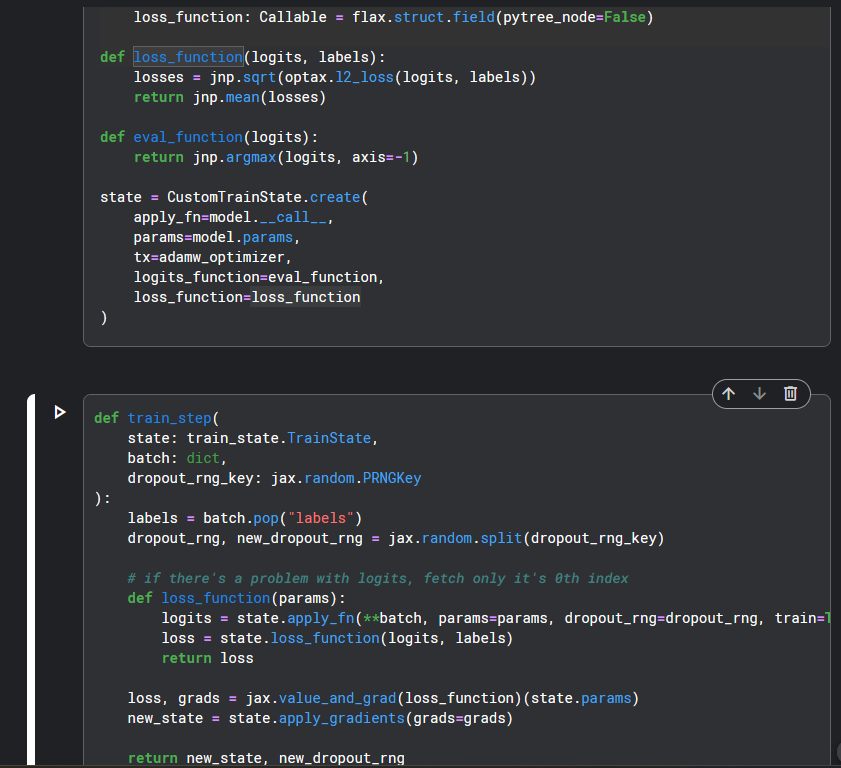

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Currently the models can't take batches of data with arrays that have different lengths. Because of that we'll have to pad all the sentences to the maximum length (i. e. to the length of the longest encoded sentence). And yes, we'll have to look through both training and testing data. It isn't that hard though!

In [9]:
max_sentence_length = 0

combined_dataframe = pd.concat([train_dataframe, test_dataframe])

for sentence in combined_dataframe.text:
    encoded_sentence = tokenizer.encode(sentence, add_special_tokens=True)
    max_sentence_length = max(len(encoded_sentence), max_sentence_length)

print(f"Maximum sentence length: {max_sentence_length} IDs")

Maximum sentence length: 84 IDs


The main encoding part is slightly more difficult. We'll have to define three arrays for input IDs, token type IDs and attention masks respectively. Then, after encoding each sentence, we'll add the encoded data to their respective arrays. Output of the function is a dictionary containing the following entries:
- `input_ids`
- `token_type_ids`
- `attention_mask`
- `labels` (**only if labels were specified!** that'll help us get them faster in the training step function)

The `IntegerMatrix` variable defines the type of our arrays, since they're gonna contain lists of lists, each of the same length and with integer values inside.

In [10]:
IntegerMatrix = list[list[int]]

def preprocess_dataframe(data: pd.Series, labels: pd.Series | None = None):
    input_ids: IntegerMatrix = []
    token_type_ids: IntegerMatrix = []
    attention_masks: IntegerMatrix = []
        
    for sentence in data:
        tokenizer_output: dict[str, list[int]] = tokenizer(
            sentence,
            add_special_tokens=True,
            padding="max_length",
            max_length=max_sentence_length,
            return_tensors="pt"
        )
        
        input_ids.append(tokenizer_output["input_ids"])
        token_type_ids.append(tokenizer_output["token_type_ids"])
        attention_masks.append(tokenizer_output["attention_mask"])

    input_ids = torch.cat(input_ids)
    token_type_ids = torch.cat(token_type_ids)
    attention_masks = torch.cat(attention_masks)
    
    if labels is not None:
        labels = torch.from_numpy(labels.to_numpy()).to(torch.float32)
        return input_ids, token_type_ids, attention_masks, labels
    else:
        return input_ids, token_type_ids, attention_masks

Using the function isn't difficult. For the train data, pass the data and the labels (`text` and `target` columns of the dataframe). For the test data, pass only the data.

In [11]:
labeled_data = preprocess_dataframe(
    train_dataframe.text,
    train_dataframe.target)

test_data = preprocess_dataframe(test_dataframe.text)

In [12]:
labeled_data

(tensor([[  101,  2256, 15616,  ...,     0,     0,     0],
         [  101,  3224,  2543,  ...,     0,     0,     0],
         [  101,  2035,  3901,  ...,     0,     0,     0],
         ...,
         [  101, 23290,  1012,  ...,     0,     0,     0],
         [  101,  2610, 11538,  ...,     0,     0,     0],
         [  101,  1996,  6745,  ...,     0,     0,     0]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

The `torch` library has a lot of data loading pipelines to utilize. One of the useful ones is `TensorDataset` - it allows you to pass any number of tensors, which will be used to create the dataset.

`labeled_dataset` will be split into training and validation datasets, hence it's name.

In [13]:
labeled_dataset = TensorDataset(*labeled_data)
test_dataset = TensorDataset(*test_data)

next(iter(labeled_dataset))

(tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
          2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

And there's yet another useful module! `random_split` allows you to split a PyTorch dataset (like the one we've created above) into an arbitrary amount of new datasets with the corresponding sizes specified in the following argument.

In [14]:
# defining dataset sizes
train_dataset_size = int(0.8 * len(labeled_dataset))
validation_dataset_size = len(labeled_dataset) - train_dataset_size

# splitting the datasets
# random_split(<dataset>, [<sizes>])
# the number of variables you're assigning the output of random_split to must be equal to the number of sizes you've specified
train_dataset, validation_dataset = random_split(labeled_dataset, [train_dataset_size, validation_dataset_size])

# checking the output of the dataset
next(iter(train_dataset))

(tensor([  101,  1030,  7158, 10760, 16715,  4364,  2000,  6015,  2000,  2265,
          2010,  2613,  2171,  4312,  2002,  4282,  1045,  1005,  2222,  5968,
          2032,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

All of that data preprocessing leads us here - creating `DataLoader`s is the last step. `DataLoader` is PyTorch's most utilized data-loading pipeline. It can batch data, shuffle it after every epoch, apply any passed function onto every batch and so on!

Samplers are also an interesting concept. They define how the data is fetched. `RandomSampler` picks batches at random, `SequentialSampler` sequentially fetches the batches, one after another. Those are the main ones we'll use.

Their usage is simple - you pass the same dataset you'll use in the dataloader. The sampler must be specified by it's keyword in the dataloader class, much like any non-dataset parameter.

We'll need the data in the output batches converted to JAX arrays, since that's the only array variant that JAX's JIT (Just-In-Time) compilation allows to be passed. More on JIT later ;)

In [15]:
def labeled_collate_fn(unprocessed_batch):
    input_ids, token_type_ids, attention_masks, labels = zip(*unprocessed_batch)

    return (
        jnp.array(input_ids),
        jnp.array(token_type_ids),
        jnp.array(attention_masks),
        jnp.array(labels, dtype=jnp.int32)
    )

def unlabeled_collate_fn(unprocessed_batch):
    input_ids, token_type_ids, attention_masks, = zip(*unprocessed_batch)

    return (
        jnp.array(input_ids),
        jnp.array(token_type_ids),
        jnp.array(attention_masks)
    )

In [16]:
batch_size = 32

# train dataloader
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    collate_fn=labeled_collate_fn
)

# validation dataloader
validation_sampler = SequentialSampler(validation_dataset)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    sampler=validation_sampler,
    collate_fn=labeled_collate_fn
)

# test dataloader
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=test_sampler,
    collate_fn=unlabeled_collate_fn
)

# checking if it works like intended
next(iter(train_dataloader))

(Array([[  101,  1005,  2017, ...,     0,     0,     0],
        [  101,  3748,  8769, ...,     0,     0,     0],
        [  101,  8299,  1024, ...,     0,     0,     0],
        ...,
        [  101,  1996,  5072, ...,     0,     0,     0],
        [  101,  1030, 13434, ...,     0,     0,     0],
        [  101,  6040,  2013, ...,     0,     0,     0]], dtype=int32),
 Array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 Array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 Array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0], dtype=int32))

# Fine-tuning the model
This is where we utilize JAX and Flax. Don't expect it to be easy, though I'll try to explain everything in details :)

We'll have to prepare:
- configurations - parameters that will be automatically specified in the model, such as whether to output attentions and hidden states.
- the model - pretrained model from `transformer`'s `FlaxAutoModelForSequenceClassification`. This is where the configurations are passed.
- `TrainState` - Flax's useful class for storing all the modules and functions used for training. In our case, it's the model's apply function, parameters (i. e. weights and biases) and the optimizer.

In [17]:
config = AutoConfig.from_pretrained(model_name, num_labels=2)
model = FlaxAutoModelForSequenceClassification.from_pretrained(model_name, config=config, seed=seed)
optimizer = optax.adamw(learning_rate=6e-5, eps=1e-8)

state = TrainState.create(
    apply_fn=model.__call__,
    params=model.params,
    tx=optimizer
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the model checkpoint at bert-large-uncased were not used when initializing FlaxBertForSequenceClassification: {('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'scale'), ('cls', 'predictions', 'transform', 'dense', 'kernel'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'predictions', 'bias')}
- This IS expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification

We don't need the model to output hidden states and attention scores every step. Let's see whether that's gonna happen:

In [18]:
print(f"Model will output the hidden states: {'YES' if config.output_hidden_states else 'NO'}")
print(f"Model will output attentions: {'YES' if config.output_attentions else 'NO'}")

Model will output the hidden states: NO
Model will output attentions: NO


Thankfully not.

Our training step will look something like this:
- Labels will be separated from the main batch.
- We'll define the loss function, which fetches the logits from the function and calculates the loss with respect to the labels.
- Loss and gradients will be fetched using JAX's `value_and_grad` wrapper.
- We'll apply the gradients using the state's `apply_gradients`, giving us a new train state.
- To continue the training, we'll return the state and the loss.

Reading documentation can give you crucial information. `FlaxBertForSequenceClassification` (i. e. the instance saved in our `model` variable) takes inputs of shape (batch_size, num_features), meaning the data must be batched. JAX's `value_and_grad` calculates the gradient only with respect to a scalar loss. That means `loss_function` has to return the average of the losses.

And as you might've already noticed, we're wrapping the single-step functions with `jax.jit`. JIT compilation reduces functions into a sequence of primitive operations, which allows them to be efficiently executed. In simpler terms, they're compiled and can be *very* quickly reused.

Obviously there are side effects of wrapping impure functions (containing `print`, using an external variable and so on) and other exceptions (e. g. you can't use if-else), though, that's besides the point, since our functions are pure.

In [19]:
@jax.jit
def train_step(
    state: TrainState,
    batch: tuple[jax.Array],
    dropout_rng: jax.random.PRNGKey
) -> tuple[TrainState, jax.Array]:
    
    batch, labels = batch[:-1], batch[-1]
    
    def loss_fn(params):
        output = state.apply_fn(*batch, params=params, dropout_rng=dropout_rng, train=True)
        logits = output.logits
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss


@jax.jit
def eval_step(
    state: TrainState,
    batch: tuple[jax.Array],
    dropout_rng: jax.random.PRNGKey
) -> jax.Array:
    batch, labels = batch[:-1], batch[-1]
    
    output = state.apply_fn(*batch, params=state.params, dropout_rng=dropout_rng, train=False)
    logits = output.logits

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()

    return loss

To simplify the training loop, we'll pack the single-step functions above in corresponding single-epoch functions defined below. It shouldn't be that hard, considering all we need to do is iterate through the dataloaders, track batch losses and divide their sum by the number of batches in the respective dataloaders (i. e. by the dataloaders' lengths).

We don't wrap them with `jax.jit` since they additionally take PyTorch's dataloaders, which can't be traced by JAX.

In [20]:
def train_epoch(
    state: TrainState,
    dataloader: DataLoader,
    dropout_rng: jax.random.PRNGKey
) -> tuple[TrainState, float]:
    
    total_loss = 0.0

    for batch in dataloader:
        dropout_rng, other_dropout_rng = jax.random.split(dropout_rng)
        state, loss = train_step(state, batch, dropout_rng)
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return state, average_loss


def eval_epoch(
    state: TrainState,
    dataloader: DataLoader,
    dropout_rng: jax.random.PRNGKey
) -> float:

    total_loss = 0.0

    for batch in dataloader:
        dropout_rng, other_dropout_rng = jax.random.split(dropout_rng)
        loss = eval_step(state, batch, dropout_rng)
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss

As you might've noticed, our divide-and-conquer strategy works quite well - the training loop is as simple as it gets.

In [21]:
epochs = 3
dropout_rng = jax.random.PRNGKey(seed)

for epoch in range(1, epochs + 1):
    dropout_rng, other_dropout_rng = jax.random.split(dropout_rng)
    print(f"Epoch {epoch}/{epochs}")

    print(f"   Training...")
    state, loss = train_epoch(state, train_dataloader, dropout_rng)
    print(f"   > Train loss: {loss:.4f}\n")

    print(f"   Evaluating...")
    loss = eval_epoch(state, validation_dataloader, other_dropout_rng)
    print(f"   > Validation loss: {loss:.4f}\n")

Epoch 1/3
   Training...
   > Train loss: 0.7149

   Evaluating...
   > Validation loss: 0.6837

Epoch 2/3
   Training...
   > Train loss: 0.7120

   Evaluating...
   > Validation loss: 0.6853

Epoch 3/3
   Training...
   > Train loss: 0.7039

   Evaluating...
   > Validation loss: 0.6997



# Prediction

For prediction, we'll use the same strategy for consistency - create a single-step function (prediction on a single batch, wrapped with JIT) and use it in a single-epoch function (prediction on the whole dataloader).

In [22]:
@jax.jit
def predict_on_batch(
    state: TrainState,
    batch: tuple[jax.Array]
) -> jax.Array:
    
    output = state.apply_fn(*batch, params=state.params, train=False)
    predictions = jnp.argmax(output.logits, axis=-1)

    return predictions

def predict_on_dataloader(
    state: TrainState,
    dataloader: DataLoader
) -> list:

    predictions = []

    for batch in dataloader:
        batch_predictions = predict_on_batch(state, batch)
        predictions.extend(np.array(batch_predictions).tolist())

    return predictions

Oh, would you look at that - predicting takes only a single line.

In [23]:
predictions = predict_on_dataloader(state, test_dataloader)
predictions[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Let's load the sample submission file from the directory we've specified in the beginning. It will be useful to quickly create a submission file for the competition.

In [24]:
submission = pd.read_csv(sample_submission_dir)
submission.sample(5)

,id,target
1771,5984,0
3260,10868,0
610,1993,0
2357,7886,0
1104,3644,0


The only thing you have to do is put the predictions in the `target` column. That's it. Your submission dataframe is ready to be converted.

The predictions array should be either a `list`, `tuple` or a `np.ndarray` instance. Those are the only array types pandas allows to use instead as columns. It's a `list` in our case, so we should be fine.

In [25]:
submission["target"] = predictions
submission.sample(5)

,id,target
2710,9021,0
1715,5786,0
992,3272,0
2008,6761,0
3191,10602,0


And that's it, the final step - converting the submission dataframe to a CSV file. It's also important to specify `index` as `False`, since otherwise Kaggle won't be able to correctly review your file.

In [26]:
submission.to_csv("submission.csv", index=False)